In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py as h5
import os
import utils
utils.SetStyle()
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
plt.rcParams["font.family"] = "serif"

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, TimeDistributed,AveragePooling1D,Reshape
from keras.models import Model, Sequential


/global/u2/v/vmikuni/NPR/utils.py:46: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
file_path = '/global/cfs/cdirs/m3929/NPR/'
file_name = 'ttbb.h5'

In [3]:
with h5.File(os.path.join(file_path,file_name),'r') as h5f:
        data = h5f['data'][:]
        weights = h5f['weights1'][:] #from first pdf option

(array([2.00000e+00, 3.00000e+00, 2.00000e+00, 6.00000e+00, 6.00000e+00,
        5.00000e+00, 6.00000e+00, 1.10000e+01, 1.60000e+01, 2.00000e+01,
        4.40000e+01, 9.70000e+01, 1.92000e+02, 1.53824e+05, 5.62360e+04,
        1.03910e+04, 5.34300e+03, 5.22400e+03, 7.55634e+05, 1.66808e+05,
        5.01880e+04, 2.73990e+04, 1.81950e+04, 1.30870e+04, 9.82700e+03,
        7.61800e+03, 6.09200e+03, 4.80000e+03, 3.97800e+03, 3.27700e+03,
        2.79300e+03, 2.38500e+03, 2.07900e+03, 1.80000e+03, 1.44900e+03,
        1.21700e+03, 1.12100e+03, 9.53000e+02, 8.27000e+02, 6.63000e+02,
        6.62000e+02, 5.44000e+02, 4.99000e+02, 4.42000e+02, 3.70000e+02,
        3.06000e+02, 3.14000e+02, 2.61000e+02, 2.39000e+02]),
 array([-5.        , -4.69387755, -4.3877551 , -4.08163265, -3.7755102 ,
        -3.46938776, -3.16326531, -2.85714286, -2.55102041, -2.24489796,
        -1.93877551, -1.63265306, -1.32653061, -1.02040816, -0.71428571,
        -0.40816327, -0.10204082,  0.20408163,  0.51020408,  0

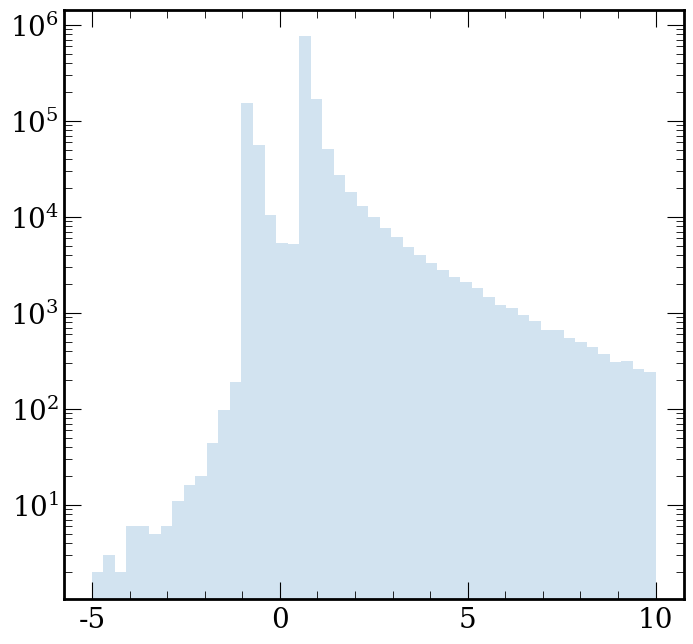

In [4]:
fig = plt.figure(figsize=(8, 7.65))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
plt.yscale("log")
weights /= np.mean(np.abs(weights))
plt.hist(weights,alpha=0.2, bins = np.linspace(-5,10,50),label="Initial Weights")

In [5]:
#Simple data preprocessing

#Convert to pt, eta, phi
pt = np.sqrt(data[:,:,0]**2 + data[:,:,1]**2)
phi = np.ma.arctan2(data[:,:,1],data[:,:,0]).filled(0)
eta = np.ma.arcsinh(np.ma.divide(data[:,:,2],pt).filled(0))

data[:,:,0] = np.ma.log(pt).filled(0)
data[:,:,1] = eta
data[:,:,2] = phi


data_mean = np.mean(data,(0,1))
data_std = np.std(data,(0,1))
data = (data - data_mean)/(data_std)



In [6]:
#Prepare the model for the reweighing
modelw = Sequential()
modelw.add(TimeDistributed(Dense(128, input_dim=4, activation='relu')))
modelw.add(TimeDistributed(Dense(128, activation='relu')))
modelw.add(AveragePooling1D(pool_size=data.shape[1]))
modelw.add(Reshape([128]))
modelw.add(Dense(256, activation='relu'))
modelw.add(Dense(1, activation='sigmoid'))

modelw2 = tf.keras.models.clone_model(modelw)

In [7]:
x_vals = np.concatenate([data,data],0)
y_vals = np.concatenate([np.ones(weights.shape[0]),np.zeros(weights.shape[0])])
w_vals = np.concatenate([weights,np.ones(weights.shape[0])])
X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(x_vals, y_vals, w_vals, test_size=0.5)

In [8]:
checkpoint_folder_w = 'checkpoints_ttbbw/checkpoint'
checkpoint_folder_w2 = 'checkpoints_ttbbw2/checkpoint'

callbacks = [
    EarlyStopping(patience=10,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-6),
        
]

In [9]:
load_model = True
if load_model:
    modelw.load_weights('{}'.format(checkpoint_folder_w)).expect_partial()
    modelw2.load_weights('{}'.format(checkpoint_folder_w2)).expect_partial()
else:    
    modelw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=[])
    modelw.fit(X_train, Y_train, 
              sample_weight=W_train,epochs=100,
              validation_data=(X_val, Y_val, W_val),
              callbacks=callbacks + [ModelCheckpoint(checkpoint_folder_w,mode='auto',
                                        save_best_only=True,
                                        period=1,save_weights_only=True)],
              batch_size=1024,verbose=1)
    modelw2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=[])
    modelw2.fit(X_train, Y_train, 
              sample_weight=W_train**2,epochs=100,
              validation_data=(X_val, Y_val, W_val),
              callbacks=callbacks + [ModelCheckpoint(checkpoint_folder_w2,mode='auto',
                                        save_best_only=True,
                                        period=1,save_weights_only=True)],
              batch_size=1024,verbose=1)

In [10]:
update_weight1 = modelw.predict(data)[:,0]
update_weight1 = update_weight1 / (1.-update_weight1)

update_weight2 = modelw2.predict(data)[:,0]
update_weight2 = update_weight2 / (1.-update_weight2)

print(update_weight1,update_weight2)

41247/41247 [==============================] - 25s 609us/step
[0.77070403 0.82859796 0.79905486 ... 0.7828767  0.7530999  0.8273177 ] [0.8748126  7.358047   1.6063561  ... 0.9185674  1.0568494  0.96095026]


## Now for reducing the stats.

In [11]:
keepprobs = (update_weight1**2)/update_weight2
keepprobs[keepprobs>1]=1.
print(keepprobs)
keep = np.random.binomial(1,keepprobs) ==1
update_weight = update_weight2/update_weight1
update_weight /= np.mean(update_weight)
print(update_weight)

print("Reduction factor: {}".format(1.0*np.sum(keep)/keep.shape[0]))
#print(data.shape)

[0.6789851  0.09330935 0.3974764  ... 0.6672302  0.5366512  0.71226853]
[0.46674627 3.651507   0.8266443  ... 0.4824709  0.5770506  0.47761944]
Reduction factor: 0.44477763466929315


In [12]:
#Undo the preprocessing
data = data_std * data + data_mean
data[:,:,0] = np.exp(data[:,:,0])

[0.46674627 3.651507   0.8266443  ... 0.4824709  0.5770506  0.47761944]


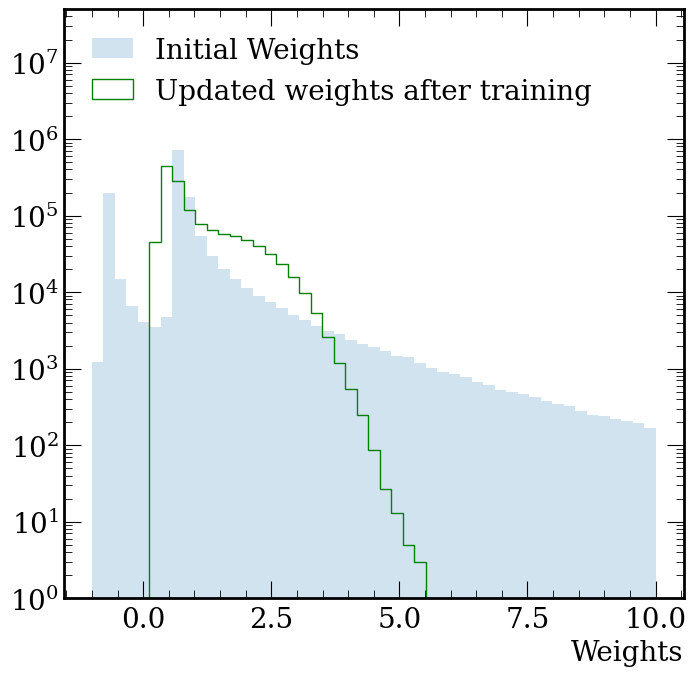

In [13]:
print(update_weight)
fig = plt.figure(figsize=(8, 7.65))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
plt.hist(weights,bins=np.linspace(-1.,10,50),alpha=0.2,label="Initial Weights")
plt.hist(update_weight,label="Updated weights after training",color="green",histtype="step",bins=np.linspace(-1,10,50))
plt.legend(frameon=False,fontsize=20,loc="upper left")

plt.xlabel(r"Weights",fontsize=20)
plt.ylim([1,5e7])
plt.yscale("log")
#plt.ylabel(r"Generated events",fontsize=20)
plt.savefig("weigths.pdf",bbox_inches='tight')

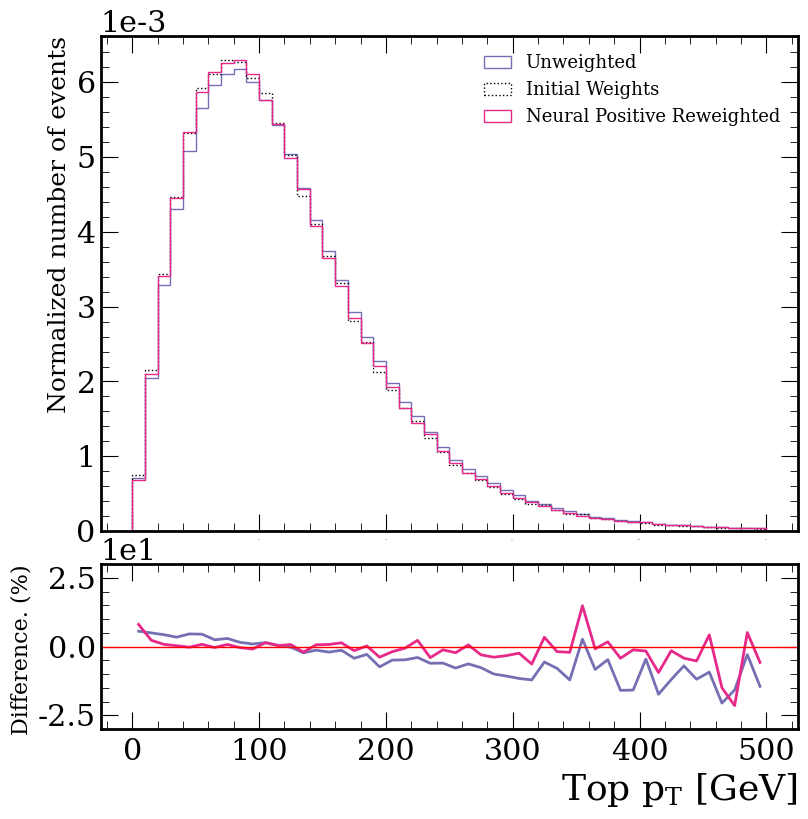

<Figure size 1000x1000 with 0 Axes>

In [14]:
import importlib

importlib.reload(utils)
feed_dict = {
    'Unweighted': data[:,0,0],
    'Initial Weights': data[:,0,0],
    'Neural Positive Reweighted': data[:,0,0][keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

utils.HistRoutine(feed_dict,xlabel=r"Top p$_T$ [GeV]",ylabel='Normalized number of events',
                  binning = np.linspace(0,500,51),weights=weights_dict)
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()
plt.savefig("top_pt.pdf",bbox_inches='tight')


(0.0, 0.3)

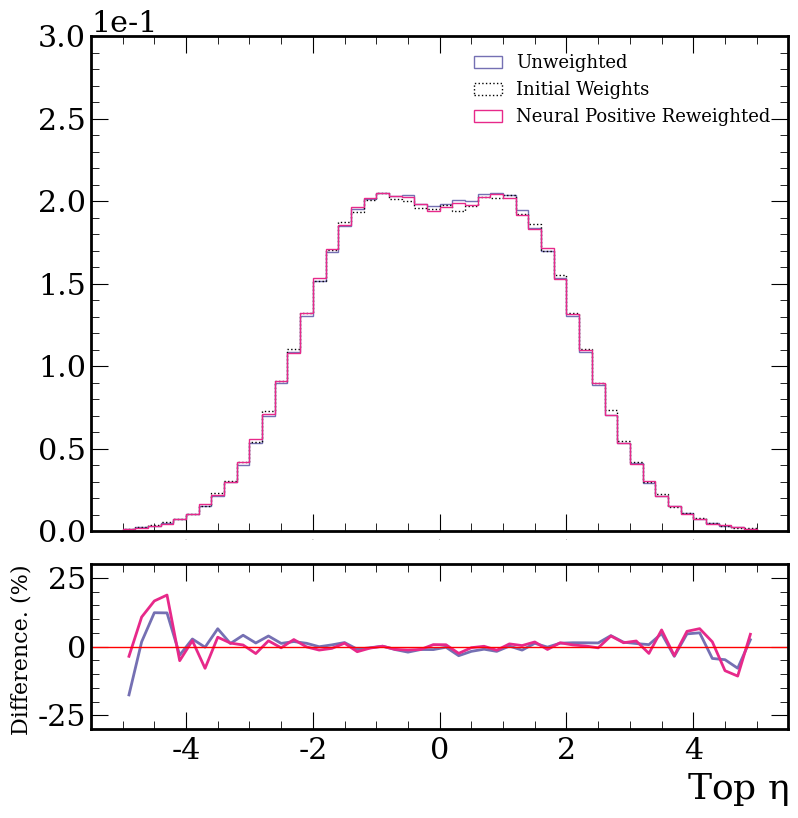

In [15]:
feed_dict = {
    'Unweighted': data[:,0,1],
    'Initial Weights': data[:,0,1],
    'Neural Positive Reweighted': data[:,0,1][keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

fig,ax = utils.HistRoutine(feed_dict,xlabel=r"Top $\eta$",binning = np.linspace(-5,5,51),weights=weights_dict)
ax.set_ylim([0,0.3])

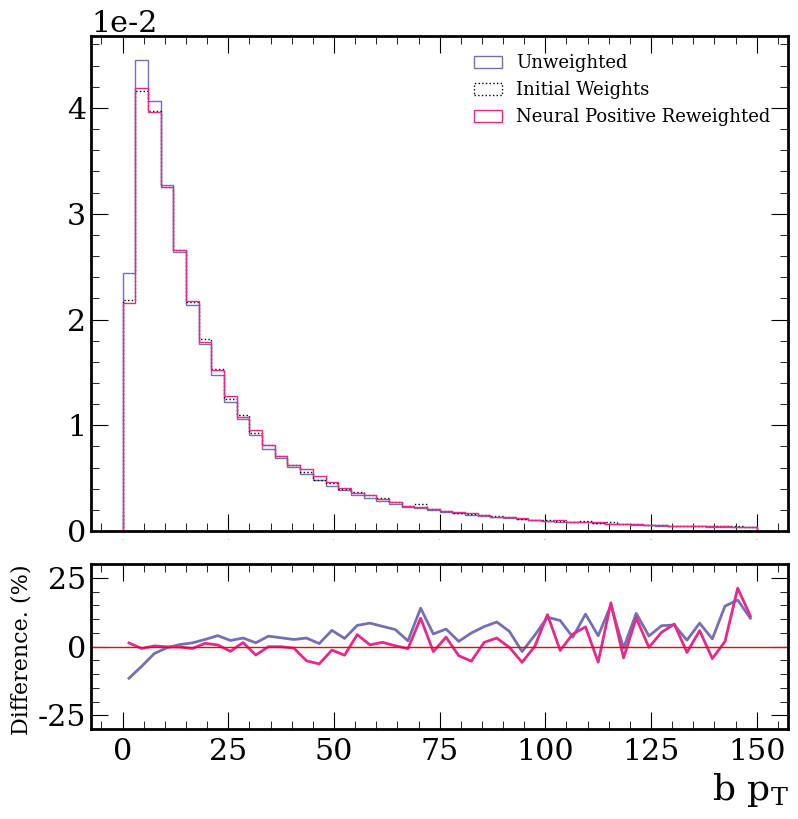

In [16]:
feed_dict = {
    'Unweighted': data[:,2,0],
    'Initial Weights': data[:,2,0],
    'Neural Positive Reweighted': data[:,2,0][keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

fig,ax = utils.HistRoutine(feed_dict,xlabel=r"b p$_T$",binning = np.linspace(0,150,51),weights=weights_dict)
#ax.set_ylim([0,0.3])
plt.savefig("b_pt.pdf",bbox_inches='tight')



(<Figure size 900x900 with 2 Axes>, <AxesSubplot: >)

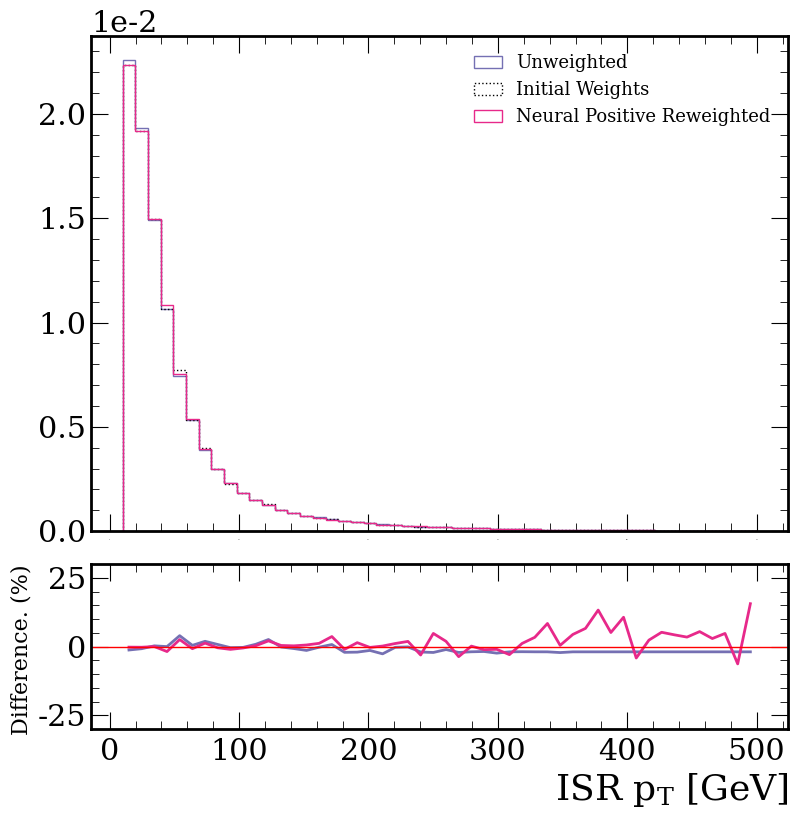

In [17]:
import importlib

importlib.reload(utils)
feed_dict = {
    'Unweighted': data[:,4,0],
    'Initial Weights': data[:,4,0],
    'Neural Positive Reweighted': data[:,-1,0][keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

utils.HistRoutine(feed_dict,xlabel=r"ISR p$_T$ [GeV]",binning = np.linspace(10,500,51),weights=weights_dict)

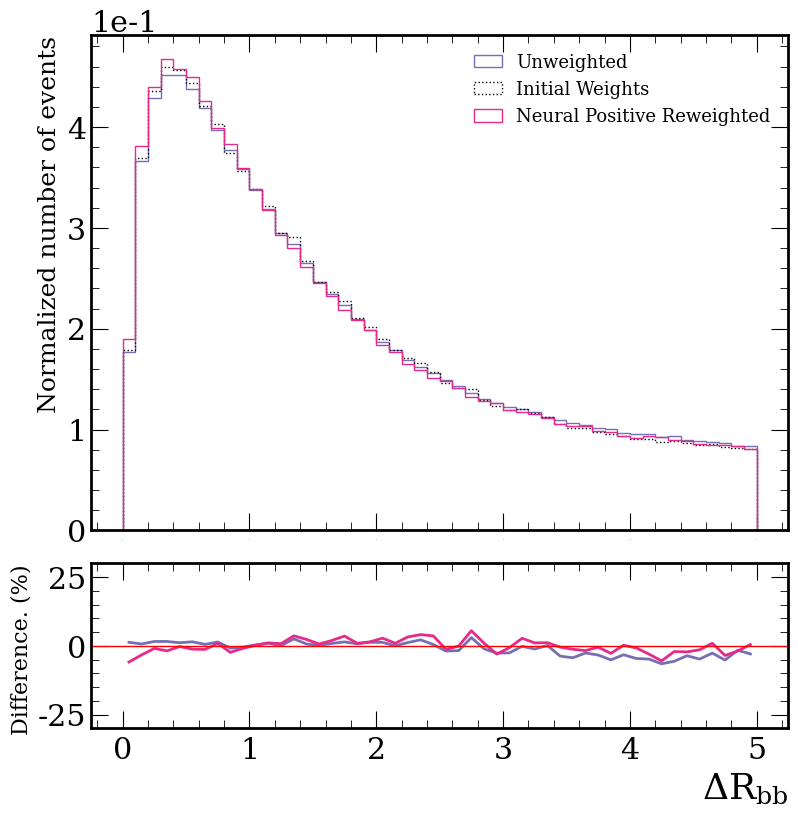

In [18]:
feed_dict = {
    'Unweighted': np.sqrt((data[:,2,1]-data[:,3,1])**2 + (data[:,2,2]-data[:,3,2])**2),
    'Initial Weights': np.sqrt((data[:,2,1]-data[:,3,1])**2 + (data[:,2,2]-data[:,3,2])**2),
    'Neural Positive Reweighted': np.sqrt((data[:,2,1]-data[:,3,1])**2 + (data[:,2,2]-data[:,3,2])**2)[keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

utils.HistRoutine(feed_dict,xlabel=r"$\Delta R_{bb}$",ylabel='Normalized number of events',binning = np.linspace(0,5,51),weights=weights_dict)
plt.savefig("dr_bb.pdf",bbox_inches='tight')


In [19]:
def get_dimass(jets):
    jet_e = np.sqrt(172.6**2 + jets[:,0,0]**2*np.cosh(jets[:,0,1])**2)
    jet_e += np.sqrt(172.6**2 + jets[:,1,0]**2*np.cosh(jets[:,1,1])**2)
    jet_px = jets[:,0,0]*np.cos(jets[:,0,2]) + jets[:,1,0]*np.cos(jets[:,1,2])
    jet_py = jets[:,0,0]*np.sin(jets[:,0,2]) + jets[:,1,0]*np.sin(jets[:,1,2])
    jet_pz = jets[:,0,0]*np.sinh(jets[:,0,1]) + jets[:,1,0]*np.sinh(jets[:,1,1])
    mjj = np.sqrt(np.abs(jet_px**2 + jet_py**2 + jet_pz**2 - jet_e**2))
    return mjj

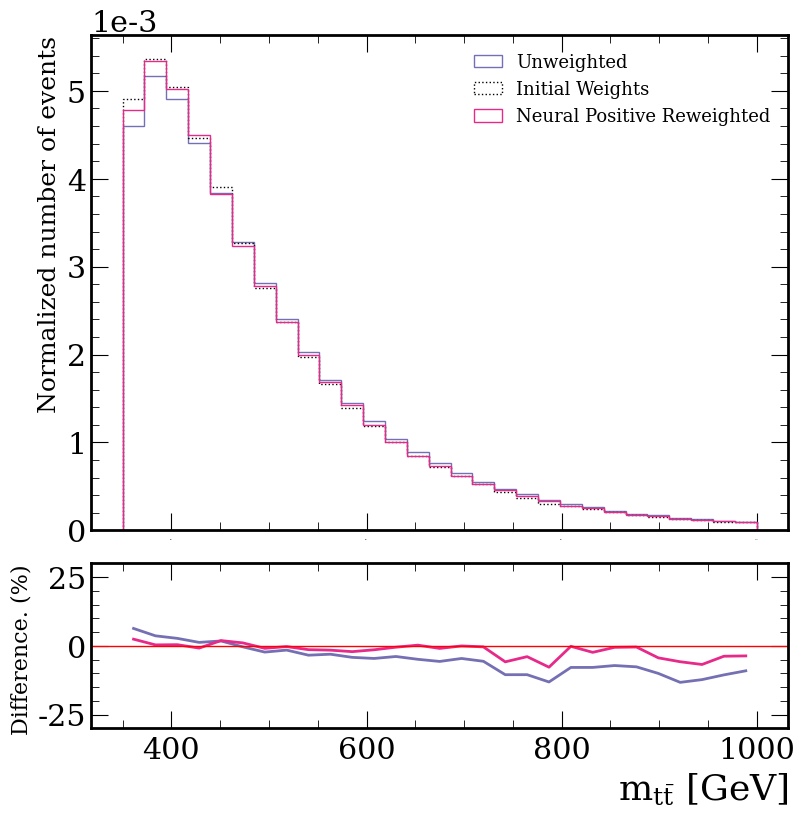

In [20]:
feed_dict = {
    'Unweighted': get_dimass(data),
    'Initial Weights': get_dimass(data),
    'Neural Positive Reweighted': get_dimass(data)[keep],
}
weights_dict = {
    'Unweighted': np.ones(data.shape[0]),
    'Initial Weights': weights,
    'Neural Positive Reweighted': update_weight[keep],
}

utils.HistRoutine(feed_dict,xlabel=r"$m_{t\bar{t}}$ [GeV]",ylabel='Normalized number of events',binning = np.linspace(350,1000,30),weights=weights_dict)
plt.savefig("mttbar.pdf",bbox_inches='tight')
